In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [3]:
train_path=r'../input/knee-osteoarthritis-dataset-with-severity/train'
test_path=r'../input/knee-osteoarthritis-dataset-with-severity/test'
valid_path=r'../input/knee-osteoarthritis-dataset-with-severity/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [12]:
# Label mapping dictionary (from earlier code)
label_mapping = {'Healthy': 0, 'Doubtful': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

# Paths for the datasets
train_path = r'../input/knee-osteoarthritis-dataset-with-severity/train'
test_path = r'../input/knee-osteoarthritis-dataset-with-severity/test'
valid_path = r'../input/knee-osteoarthritis-dataset-with-severity/val'

# List of classes as strings
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

# Iterate over the paths and process each folder (train, test, valid)
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels = [] 
    classlist = os.listdir(d)  # Get the class folders (Healthy, Doubtful, etc.)
    
    for klass in classlist:
        intklass = int(klass)  # Convert folder name (class number) to integer
        label_name = list_of_classes[intklass]  # Get the corresponding class label as a string
        label = label_mapping[label_name]  # Map the label to a numeric value using label_mapping
        
        classpath = os.path.join(d, klass)  # Get the path of the class folder
        flist = os.listdir(classpath)  # List all files (images) in the class folder        
        for f in flist:
            fpath = os.path.join(classpath, f)  # Get the full file path
            filepaths.append(fpath)
            labels.append(label)  # Add the mapped numeric label
    
    # Create DataFrame for each dataset (train, test, valid)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')        
    pdf = pd.concat([Fseries, Lseries], axis=1)
    
    # Assign DataFrame to corresponding dataset variable
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf

# Print dataset sizes
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# Get the number of classes and the images count for each class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

# Group by labels and print class image counts
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist = []
classlist = []
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30} {1:^13}'.format(label, str(len(group))))  # Removed 's' and fixed formatting

# Get the classes with the minimum and maximum number of train images
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]
min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images= ', max_value, ' ', min_class, ' has the least images= ', min_value)

# Get the average height and width of a sample of the train images
ht = 0
wt = 0
# Select 100 random samples of train_df
train_df_sample = train_df.sample(n=100, random_state=123, axis=0)
for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]
    
print('average height= ', ht // 100, ' average width= ', wt // 100, 'aspect ratio= ', ht / wt)


train_df length:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
              0                    2286     
              1                    1046     
              2                    1516     
              3                     757     
              4                     173     
0  has the most images=  2286   4  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [4]:
# Label mapping dictionary (from earlier code)
label_mapping = {'Healthy': 0, 'Doubtful': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

# Paths for the datasets
train_path = r'../input/knee-osteoarthritis-dataset-with-severity/train'
test_path = r'../input/knee-osteoarthritis-dataset-with-severity/test'
valid_path = r'../input/knee-osteoarthritis-dataset-with-severity/val'

# List of classes as strings
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

# Classes to drop
drop_classes = [1, 2]  # 'Doubtful' and 'Minimal'

# Iterate over the paths and process each folder (train, test, valid)
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels = [] 
    classlist = os.listdir(d)  # Get the class folders (Healthy, Doubtful, etc.)
    
    for klass in classlist:
        intklass = int(klass)  # Convert folder name (class number) to integer
        if intklass in drop_classes:
            continue  # Skip classes to be dropped
        label_name = list_of_classes[intklass]  # Get the corresponding class label as a string
        label = label_mapping[label_name]  # Map the label to a numeric value using label_mapping
        
        classpath = os.path.join(d, klass)  # Get the path of the class folder
        flist = os.listdir(classpath)  # List all files (images) in the class folder        
        for f in flist:
            fpath = os.path.join(classpath, f)  # Get the full file path
            filepaths.append(fpath)
            labels.append(label)  # Add the mapped numeric label
    
    # Create DataFrame for each dataset (train, test, valid)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')        
    pdf = pd.concat([Fseries, Lseries], axis=1)
    
    # Assign DataFrame to corresponding dataset variable
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf

# Print dataset sizes
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# Get the number of classes and the images count for each class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

# Group by labels and print class image counts
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist = []
classlist = []
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30} {1:^13}'.format(label, str(len(group))))  # Removed 's' and fixed formatting

# Get the classes with the minimum and maximum number of train images
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]
min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images= ', max_value, ' ', min_class, ' has the least images= ', min_value)

# Get the average height and width of a sample of the train images
ht = 0
wt = 0
# Select 100 random samples of train_df
train_df_sample = train_df.sample(n=100, random_state=123, axis=0)
for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]
    
print('average height= ', ht // 100, ' average width= ', wt // 100, 'aspect ratio= ', ht / wt)


train_df length:  3216   test_df length:  913   valid_df length:  461
The number of classes in the dataset is:  3
            CLASS               IMAGE COUNT 
              0                    2286     
              3                     757     
              4                     173     
0  has the most images=  2286   4  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [6]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = working_dir  # Use the original working directory for augmentations

    # Ensure directories for all classes exist
    for label in df['labels'].unique():
        target_dir = os.path.join(aug_dir, str(label))  # Directory for the current class
        os.makedirs(target_dir, exist_ok=True)  # Create class directory if it doesn't exist

    for label in df['labels'].unique():
        # Check if the class already has the desired number of images
        group = df[df['labels'] == label]
        sample_count = len(group)
        
        if sample_count < n:
            delta = n - sample_count  # Calculate how many augmented images to generate
            target_dir = os.path.join(aug_dir, str(label))  # Directory for the current class
            
            # Convert the label to a string for proper formatting
            msg = '{0:40s} for class {1:^30s} creating {2:^5d} augmented images'.format(' ', str(label), delta)
            print(msg, '\r', end='')  # prints over on the same line
            
            # Create the ImageDataGenerator object with desired augmentations
            gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                                      height_shift_range=.2, zoom_range=.2)
            
            aug_gen = gen.flow_from_dataframe(
                group, 
                x_col='filepaths', 
                y_col=None, 
                target_size=img_size,
                class_mode=None, 
                batch_size=1, 
                shuffle=False, 
                save_to_dir=target_dir, 
                save_prefix='aug-', 
                color_mode='rgb', 
                save_format='jpg'
            )
            
            aug_img_count = 0
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            print(f'Augmented {aug_img_count} images for class {label}')
    
    # Update the dataframe with the augmented images
    aug_fpaths = []
    aug_labels = []
    for label in df['labels'].unique():
        class_dir = os.path.join(aug_dir, str(label))
        
        # Check if the class directory exists before listing files
        if os.path.exists(class_dir):
            flist = os.listdir(class_dir)
            for f in flist:
                if f.endswith('.jpg'):  # Ensure that only augmented .jpg files are considered
                    fpath = os.path.join(class_dir, f)
                    aug_fpaths.append(fpath)
                    aug_labels.append(label)
        else:
            print(f"Warning: Directory {class_dir} does not exist or is empty.")
    
    # Create a new DataFrame for augmented images
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    
    # Merge the original and augmented dataframes
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n = 500  # target number of samples for each class
working_dir = r'./'  # directory where images are stored
img_size = (224, 224)  # size of augmented images
train_df = balance(train_df, n, working_dir, img_size)


Initial length of dataframe is  1173
Found 173 validated image filenames.     for class               4                creating  327  augmented images 
Augmented 327 images for class 4
Length of augmented dataframe is now  1500


In [7]:
# Print the number of samples in each class
class_counts = train_df['labels'].value_counts()

# Print the class counts
for label, count in class_counts.items():
    print(f"Class {label} has {count} samples.")


Class 0 has 500 samples.
Class 3 has 500 samples.
Class 4 has 500 samples.


In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [9]:
print (train_df['labels'].value_counts())

0    500
3    500
4    500
Name: labels, dtype: int64


In [10]:
max_samples=500 
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [11]:
# Convert labels to strings
train_df['labels'] = train_df['labels'].astype(str)
valid_df['labels'] = valid_df['labels'].astype(str)
test_df['labels'] = test_df['labels'].astype(str)

In [12]:
batch_size=16 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.           for train generator 
Found 461 validated image filenames belonging to 3 classes.            for valid generator 
Found 913 validated image filenames belonging to 3 classes.            for test generator 
test batch size:  11   test steps:  83  number of classes :  3


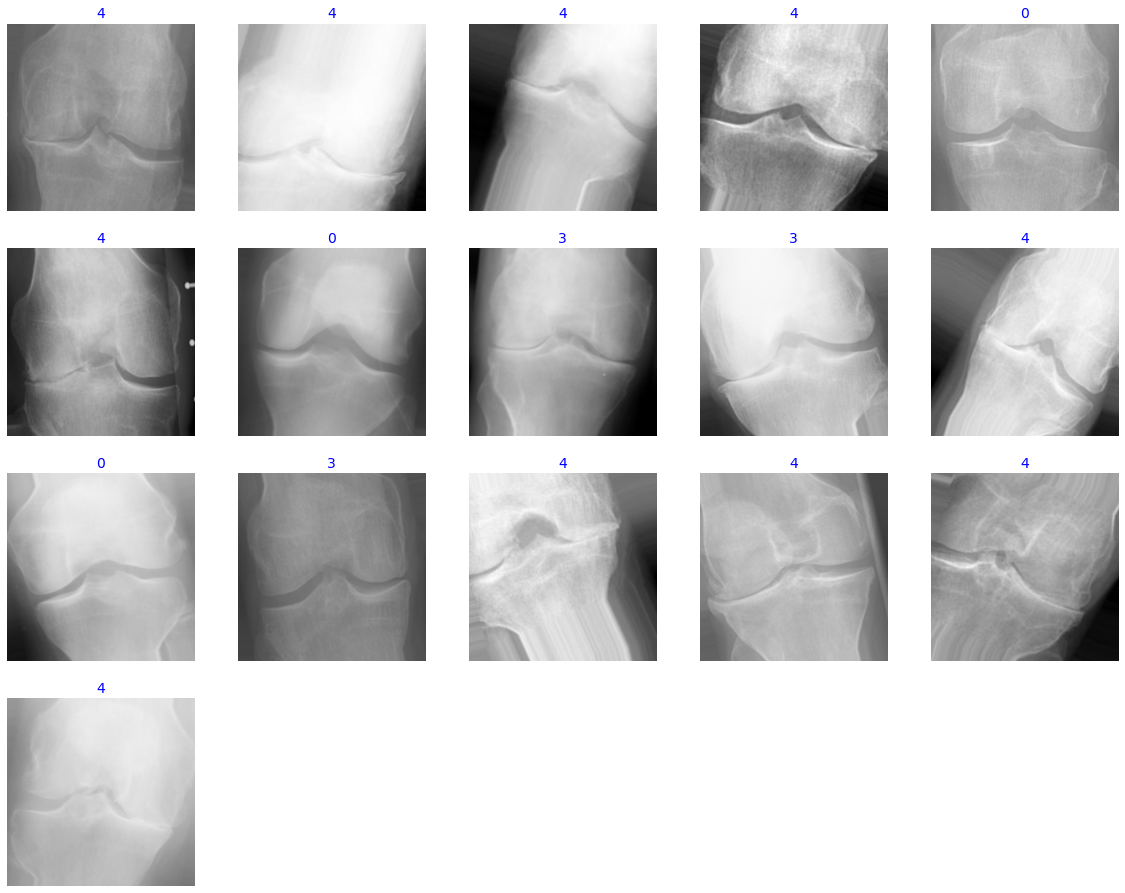

In [32]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Concatenate, Conv2D, Multiply, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

# Clear session and reset the graph
tf.keras.backend.clear_session()

# Define input shape
img_shape = (img_size[0], img_size[1], 3)

# Single input for all models
input_tensor = tf.keras.Input(shape=img_shape)

# Load InceptionResNetV2 and MobileNetV2 base models
inceptionresnet_base = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)
inceptionresnet_base.trainable = True

mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)
mobilenet_base.trainable = True

# Extract features from InceptionResNetV2 and MobileNetV2
inceptionresnet_features = inceptionresnet_base.output
mobilenet_features = mobilenet_base.output

# Apply Global Average Pooling to features
inceptionresnet_features = GlobalAveragePooling2D(name='inceptionresnet_pool')(inceptionresnet_features)
mobilenet_features = GlobalAveragePooling2D(name='mobilenet_pool')(mobilenet_features)

# Concatenate the features extracted from InceptionResNetV2 and MobileNetV2
combined_features = Concatenate(name='concat_inceptionresnet_mobilenet')([inceptionresnet_features, mobilenet_features])

# Add BatchNormalization and Dense layers
x = BatchNormalization(name='batch_norm_combined')(combined_features)
x = Dense(256, activation='relu', name='dense_combined')(x)
x = Dropout(0.4, seed=123, name='dropout_combined')(x)

# Load EfficientNetB5 base model
efficientnet_base = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)
efficientnet_base.trainable = True

# Function to implement CBAM
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.expand_dims(avg_pool, axis=1)
    avg_pool = tf.expand_dims(avg_pool, axis=1)

    max_pool = GlobalMaxPooling2D()(input_feature)  
    max_pool = tf.expand_dims(max_pool, axis=1)
    max_pool = tf.expand_dims(max_pool, axis=1)

    shared_layer_one = Conv2D(channel // ratio, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal', use_bias=False)
    shared_layer_two = Conv2D(channel, (1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)

    avg_out = shared_layer_one(avg_pool)
    avg_out = shared_layer_two(avg_out)
    max_out = shared_layer_one(max_pool)
    max_out = shared_layer_two(max_out)

    channel_attention = Add()([avg_out, max_out])
    channel_attention = tf.keras.activations.sigmoid(channel_attention)

    # Apply Channel Attention
    channel_refined_feature = Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool = tf.reduce_mean(channel_refined_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(channel_refined_feature, axis=-1, keepdims=True)
    spatial_attention = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(spatial_attention)

    # Apply Spatial Attention
    refined_feature = Multiply()([channel_refined_feature, spatial_attention])

    return refined_feature

# Apply CBAM to the EfficientNetB5 output
efficientnet_features = efficientnet_base.output
efficientnet_features = cbam_block(efficientnet_features)

# Global Average Pooling after CBAM
efficientnet_features = GlobalAveragePooling2D(name='efficientnetb5_pool')(efficientnet_features)

# Combine the features from InceptionResNet, MobileNet, and EfficientNet with CBAM
final_combined_features = Concatenate(name='final_concat')([x, efficientnet_features])

# Add BatchNormalization and Dense layers to final combined features
final_x = BatchNormalization(name='final_batch_norm')(final_combined_features)
final_x = Dense(512, activation='relu', name='final_dense')(final_x)
final_x = Dropout(0.5, seed=123, name='final_dropout')(final_x)

# Output layer (classification layer)
output = Dense(class_count, activation='softmax', name='output')(final_x)

# Define the model
model_ime = Model(inputs=input_tensor, outputs=output)

# Compile the model
lr = 0.001  # Learning rate
model_ime.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary (optional)
# model_ime.summary()


115277824/115263384 [==============================] - 4s 0us/step


In [26]:
epochs=40
ask_epoch=10
ask=LR_ASK(model_ime, epochs,  ask_epoch)
callbacks=[ask]
history=model_ime.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
94/94 [==============================] - 69s 730ms/step - loss: 0.1100 - accuracy: 0.9647 - val_loss: 0.2765 - val_accuracy: 0.9306

 validation loss of  0.2765 is below lowest loss, saving weights from epoch 1   as best weights
Epoch 2/40
94/94 [==============================] - 69s 732ms/step - loss: 0.1111 - accuracy: 0.9620 - val_loss: 0.4143 - val_accuracy: 0.9024

 validation loss of  0.4143 is above lowest loss of  0.2765 keeping weights from epoch 1 as best weights
Epoch 3/40
94/94 [==============================] - 69s 732ms/step - loss: 0.1206 - accuracy: 0.9593 - val_loss: 0.2961 - val_accuracy: 0.9154

 validation loss of  0.2961 is above lowest loss of  0.2765 keeping weights from epoch 1 as best weights
Epoch 4/40
94/94 [==============================] - 69s 732ms/step - loss: 0.0893 - accuracy: 0.9667

 h


you entered  h  Training halted on epoch  10  due to user input

loading model with weights from epoch  10
training elapsed time was 0.0 hours, 11.0 minutes, 35.84 seconds)


83/83 [==============================] - 9s 110ms/step
There were 31 errors in 913 tests for an accuracy of  96.60


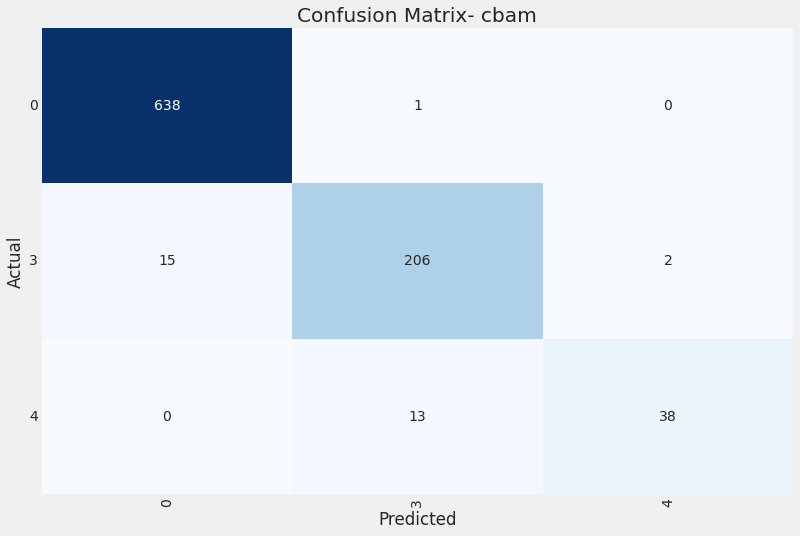

IME Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.9770    0.9984    0.9876       639
           3     0.9364    0.9238    0.9300       223
           4     0.9500    0.7451    0.8352        51

    accuracy                         0.9660       913
   macro avg     0.9545    0.8891    0.9176       913
weighted avg     0.9656    0.9660    0.9650       913



In [27]:
def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    
    # Using model_ir instead of model
    preds = model_ime.predict(test_gen, verbose=1)
    tests = len(preds)
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]  # labels are integer values
        if pred_index != true_index:  
            errors += 1
            file = test_gen.filenames[i]
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # Plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix- cbam")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # Create classification report
    print("IME Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Replace `model` with `model_ir`
errors, tests = predictor(test_gen, test_steps)


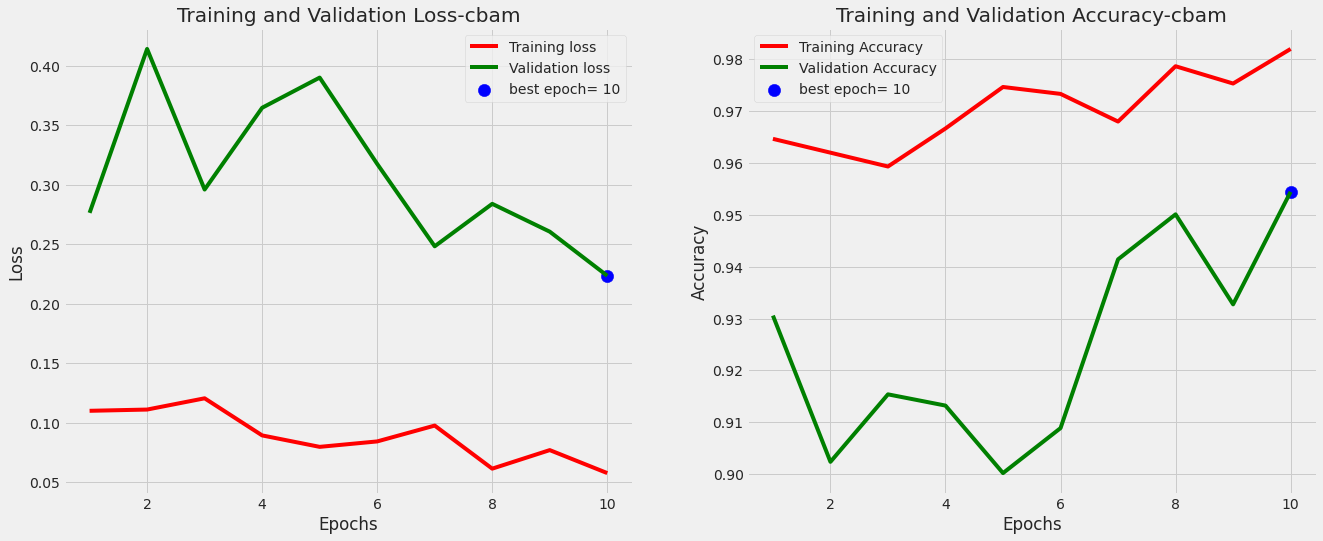

In [28]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss-cbam')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy-cbam')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [29]:
working_dir='/kaggle/working/'
subject='knee' 
acc=str(( 1-errors/tests) * 1000)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model_ime.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as  /kaggle/working/knee_966.04.h5


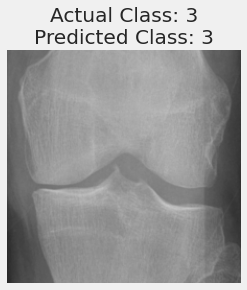

In [33]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model_path = '/kaggle/working/knee_948.52.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Define the image path (replace this with your image path)
img_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/4/9012867R.png'  # Replace with the actual image path

# Preprocess the input image (resize, convert to array, normalize)
img = image.load_img(img_path, target_size=(224, 224))  # Replace (224, 224) with the expected input size of your model
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if the model was trained with ImageNet weights (or according to your training setup)

# Perform inference
predictions = loaded_model.predict(img_array)

# Get the predicted class index (highest probability)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class index and the prediction probabilities
plt.imshow(image.load_img(img_path))
plt.axis('off')  # Hide axis
print(f"Predicted class: {predicted_class[0]}")
plt.show()

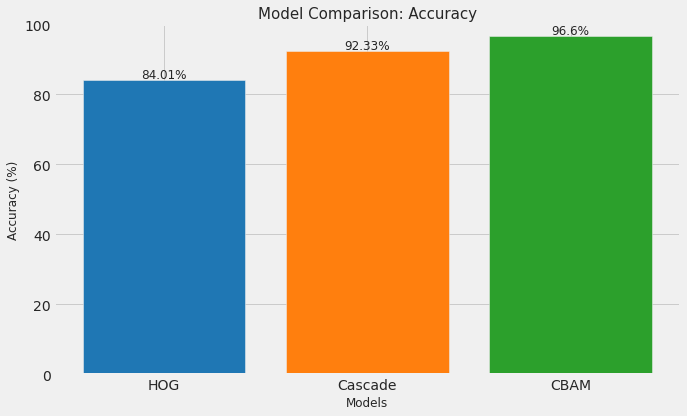

In [32]:
import matplotlib.pyplot as plt

# Define model names and their respective accuracies
models = ['HOG', 'Cascade', 'CBAM']
accuracies = [84.01, 92.33, 96.60]

# Plot the model accuracies
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Comparison: Accuracy', fontsize=15)
plt.ylim(0, 100)

# Display values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f'{acc}%', ha='center', fontsize=12)

# Show the plot
plt.show()


In [1]:
!pip freeze > requirements.txt
